In [17]:
import numpy as np
import tensorflow as tf
from typing import Dict, List, Tuple
from dataclasses import dataclass

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from ncps import wirings 
from ncps.tf import LTC


# import helper functions
from utils import *


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from ncps import wirings
from ncps.tf import LTC

from typing import Tuple, Optional
from tensorflow.keras import layers, models, optimizers

import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import pickle


In [18]:

@dataclass
class ModelMetrics:
    """Metrics for comparing bio-inspired vs classical architectures"""
    params_count: int
    flops_per_inference: int
    memory_usage: float
    temporal_dependencies: float
    sparsity: float
    biological_plausibility: float

class ArchitectureAnalyzer:
    def __init__(self, model: tf.keras.Model):
        self.model = model
        
    def compute_model_metrics(self) -> ModelMetrics:
        """Compute comprehensive metrics for model comparison"""
        # Parameter count
        params = self.model.count_params()
        
        # Estimate FLOPs
        flops = self._estimate_flops()
        
        # Memory profiling
        memory = self._profile_memory()
        
        # Temporal analysis
        temporal_score = self._analyze_temporal_dependencies()
        
        # Sparsity analysis
        sparsity = self._compute_sparsity()
        
        # Bio-plausibility score
        bio_score = self._assess_biological_plausibility()
        
        return ModelMetrics(
            params_count=params,
            flops_per_inference=flops,
            memory_usage=memory,
            temporal_dependencies=temporal_score,
            sparsity=sparsity,
            biological_plausibility=bio_score
        )
    
    def _estimate_flops(self) -> int:
        """Estimate FLOPs for one forward pass"""
        total_flops = 0
        for layer in self.model.layers:
            if isinstance(layer, (tf.keras.layers.Dense, LTC)):
                weights = layer.get_weights()[0]
                # Count multiply-adds
                total_flops += np.prod(weights.shape) * 2
        return total_flops
    
    def _profile_memory(self) -> float:
        """Profile peak memory usage during inference"""
        # Use tf.profiler or memory_profiler
        pass
    
    def _analyze_temporal_dependencies(self) -> float:
        """Analyze temporal dependency patterns"""
        # Analyze activation patterns over time
        # Higher score = stronger temporal dependencies
        pass
    
    def _compute_sparsity(self) -> float:
        """Compute weight sparsity"""
        total_weights = 0
        zero_weights = 0
        for layer in self.model.layers:
            if hasattr(layer, 'get_weights'):
                weights = layer.get_weights()[0]
                total_weights += weights.size
                zero_weights += np.sum(weights == 0)
        return zero_weights / total_weights if total_weights > 0 else 0
    
    def _assess_biological_plausibility(self) -> float:
        """Score biological plausibility"""
        score = 0.0
        
        # Check for bio-inspired features
        if any(isinstance(layer, LTC) for layer in self.model.layers):
            score += 0.3  # Local computation
            score += 0.2  # Sparse connectivity
            
        # Check activation functions
        if any(layer.activation.__name__ == 'tanh' 
               for layer in self.model.layers 
               if hasattr(layer, 'activation')):
            score += 0.2  # Biological activation
            
        return score

def compare_architectures(ltc_model: tf.keras.Model, 
                         rnn_model: tf.keras.Model,
                         test_data: np.ndarray) -> Dict:
    """Compare LTC vs RNN architectures"""
    ltc_analyzer = ArchitectureAnalyzer(ltc_model)
    rnn_analyzer = ArchitectureAnalyzer(rnn_model)
    
    ltc_metrics = ltc_analyzer.compute_model_metrics()
    rnn_metrics = rnn_analyzer.compute_model_metrics()
    
    return {
        'LTC': {
            'metrics': ltc_metrics,
            'strengths': [
                'Biological plausibility',
                'Sparse connectivity',
                'Local computation'
            ],
            'weaknesses': [
                'Training complexity',
                'Parameter sensitivity'
            ]
        },
        'RNN': {
            'metrics': rnn_metrics,
            'strengths': [
                'Training stability',
                'Parameter efficiency',
                'Proven effectiveness'
            ],
            'weaknesses': [
                'Dense connectivity',
                'Global computation',
                'Less biological'
            ]
        }
    }

In [19]:
def generate_multiple_sinusoidal_data(num_samples: int, length: int, 
                                      noise_level: float = 0.1) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate multiple samples of sine+cosine inputs and sine-based outputs 
    (with some noise added to the outputs).
    """
    data_x_list = []
    data_y_list = []
    
    for _ in range(num_samples):
        # Base signals
        sin_wave = np.sin(np.linspace(0, 3 * np.pi, length))
        cos_wave = np.cos(np.linspace(0, 3 * np.pi, length))
        
        # Shape: (1, length, 2)
        input_data = np.stack([sin_wave, cos_wave], axis=1)
        input_data = np.expand_dims(input_data, axis=0).astype(np.float32)
        
        # Target signal
        output_data = np.sin(np.linspace(0, 6 * np.pi, length))
        output_data = output_data.reshape(1, length, 1).astype(np.float32)
        
        # Random noise for target
        noise = noise_level * np.random.normal(size=(1, length, 1)).astype(np.float32)
        output_data_noisy = output_data + noise
        
        data_x_list.append(input_data)
        data_y_list.append(output_data_noisy)
    
    # Stack up to shape: (num_samples, length, 2) and (num_samples, length, 1)
    data_x = np.vstack(data_x_list)
    data_y = np.vstack(data_y_list)
    return data_x, data_y



def split_data(data_x: np.ndarray, data_y: np.ndarray, test_size: float = 0.2, val_size: float = 0.2) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X_train, X_temp, y_train, y_temp = train_test_split(data_x, data_y, test_size=(test_size + val_size))
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (test_size + val_size)))
    return X_train, y_train, X_val, y_val, X_test, y_test


In [22]:

def compile_model(model: models.Sequential, learning_rate: float, loss: str, gradient_clip: float) -> models.Sequential:
    optimizer = optimizers.Adam(
        learning_rate=learning_rate,
        clipnorm=gradient_clip
    )
    model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])
    return model


def create_ltc_model(wiring: object, activation: str = 'linear', loss: str = 'mean_squared_error', input_shape: Tuple[Optional[int], int] = (None, 2), learning_rate: float = 0.01, dropout_rate: float = 0.2, gradient_clip: float = 1.0) -> models.Sequential:
    try:
        model = models.Sequential([
            layers.InputLayer(input_shape=input_shape),
            LTC(wiring, return_sequences=True),
            layers.Dense(1, activation=activation)
        ])
        return compile_model(model, learning_rate, loss, gradient_clip)
    except Exception as e:
        print(f"Error creating LTC model: {e}")
        return None

def create_rnn_model(mid_layer: layers.Layer, activation: str = 'linear', loss: str = 'mean_squared_error', input_shape: Tuple[Optional[int], int] = (None, 2), learning_rate: float = 0.01, dropout_rate: float = 0.2, gradient_clip: float = 1.0) -> models.Sequential:
    try:
        model = models.Sequential([
            layers.InputLayer(input_shape=input_shape),
            mid_layer,
            layers.Dense(1, activation=activation)
        ])
        return compile_model(model, learning_rate, loss, gradient_clip)
    except Exception as e:
        print(f"Error creating RNN model: {e}")
        return None

In [26]:
noise_levels = [0.1, 0.2, 0.5]# [0, 0.1, 0.2, 0.5]
sequence_lengths = [24]#, 48, 96]
num_samples = 1000

## Models
learning_rates = [0.001, 0.01, 0.1]#[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
num_neurons = [4, 64]#[4, 8, 16, 32, 64]

batch_sizes = [10] #[1, 8]
epochs = 10

LTC_wiring_options = {}
RNN_mid_layer_options = {}

n_neurons = num_neurons[0]

LTC_wiring_options[f'AutoNCP_{n_neurons}'] = wirings.AutoNCP(n_neurons, 1)
LTC_wiring_options[f'RandomSparsity75_{n_neurons}'] = wirings.Random(n_neurons, 1, sparsity_level=0.75)
LTC_wiring_options[f'FullyConnected_{n_neurons}'] = wirings.FullyConnected(n_neurons, 1)

RNN_mid_layer_options[f'LSTM_{n_neurons}'] = layers.LSTM(n_neurons, return_sequences=True)
RNN_mid_layer_options[f'bi-RNN_{n_neurons}'] = layers.Bidirectional(layers.SimpleRNN(n_neurons, return_sequences=True))
RNN_mid_layer_options[f'bi-LSTM_{n_neurons}'] = layers.Bidirectional(layers.LSTM(n_neurons, return_sequences=True))
RNN_mid_layer_options[f'GRU_{n_neurons}'] = layers.GRU(n_neurons, return_sequences=True)


length = sequence_lengths[0]
noise_level = noise_levels[0]
learning_rate = learning_rates[0]
batch_size = batch_sizes[0]
wiring = LTC_wiring_options[f'AutoNCP_{n_neurons}']

data_x, data_y = generate_multiple_sinusoidal_data(num_samples, length, noise_level)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data_x, data_y)

# LTC
ltc_model = create_ltc_model(wiring)
model.compile(optimizer=optimizers.Adam(learning_rate), loss='mean_squared_error')

# RNN
mid_layer = RNN_mid_layer_options[f'LSTM_{n_neurons}']
rnn_model = create_rnn_model(mid_layer)
rnn_model.compile(optimizer=optimizers.Adam(learning_rate), loss='mean_squared_error')

# Train models
ltc_history = ltc_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)
rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)

# Compare models

# Evaluate on test data
test_loss = model.evaluate(X_test, y_test, verbose=0)


In [27]:
# Compare architectures
comparison = compare_architectures(ltc_model, rnn_model, X_test)

# Print insights
for arch, results in comparison.items():
    print(f"\n{arch} Architecture:")
    print(f"Metrics: {results['metrics']}")
    print(f"Strengths: {results['strengths']}")
    print(f"Weaknesses: {results['weaknesses']}")


LTC Architecture:
Metrics: ModelMetrics(params_count=116, flops_per_inference=10, memory_usage=None, temporal_dependencies=None, sparsity=0.0, biological_plausibility=0.5)
Strengths: ['Biological plausibility', 'Sparse connectivity', 'Local computation']
Weaknesses: ['Training complexity', 'Parameter sensitivity']

RNN Architecture:
Metrics: ModelMetrics(params_count=117, flops_per_inference=8, memory_usage=None, temporal_dependencies=None, sparsity=0.0, biological_plausibility=0.2)
Strengths: ['Training stability', 'Parameter efficiency', 'Proven effectiveness']
Weaknesses: ['Dense connectivity', 'Global computation', 'Less biological']


1/1 [==============================] - 1s 1s/step


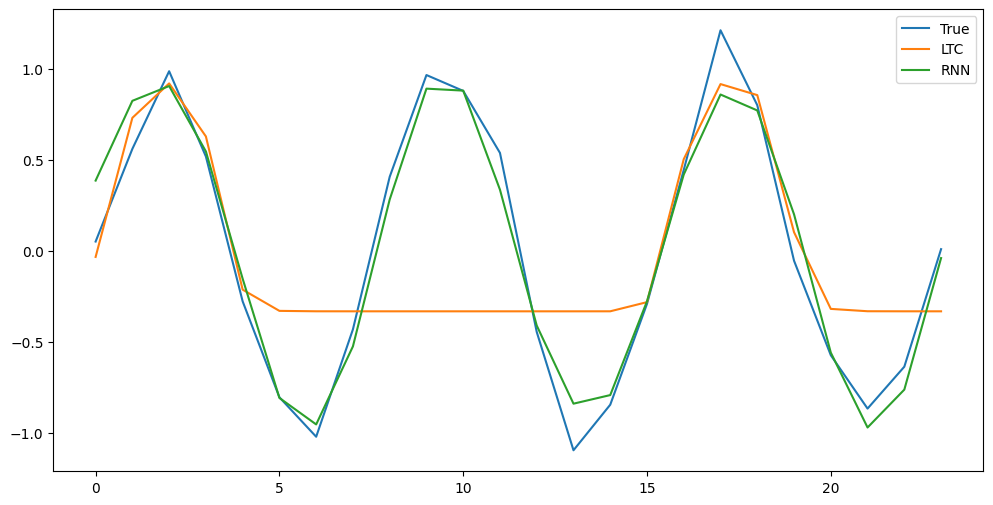

In [28]:
# can you help me plot a sample of the x/y data and the predictions of the two models?

# Plot a sample of the data
sample_idx = 0
sample_X = X_test[sample_idx]
sample_y = y_test[sample_idx]

# Predictions
ltc_pred = ltc_model.predict(sample_X[np.newaxis, ...])[0]
rnn_pred = rnn_model.predict(sample_X[np.newaxis, ...])[0]

plt.figure(figsize=(12, 6))
plt.plot(sample_y, label='True')
plt.plot(ltc_pred, label='LTC')
plt.plot(rnn_pred, label='RNN')
plt.legend()
plt.show()

